# Gesundheitsministerium and ECDC Data

## Setup

### Imports

In [98]:
%matplotlib notebook

import logging
logging.basicConfig(level=logging.ERROR)

import calendar

from datetime import timedelta, datetime

from matplotlib import pyplot as plt
#plt.style.use('dark_background')
plt.style.use('seaborn')


import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth',None)

from helper import *
from austria import Austria
from ecdc import ECDC

today =f'{datetime.now().year}_{datetime.now().month:02d}_{datetime.now().day:02d}'
ecdc = ECDC()
AT = Austria()
print("TODAY: ", datetime.now(), "\nLatest case date: ", AT.epicurve.time.max(),
      "\nTimestamps: ", AT.epicurve.Timestamp.unique())

TODAY:  2021-01-04 09:25:48.784194 
Latest case date:  2021-01-03 00:00:00 
Timestamps:  ['2021-01-04T09:02:00']


## Cases


### Weekly

<IPython.core.display.Javascript object>


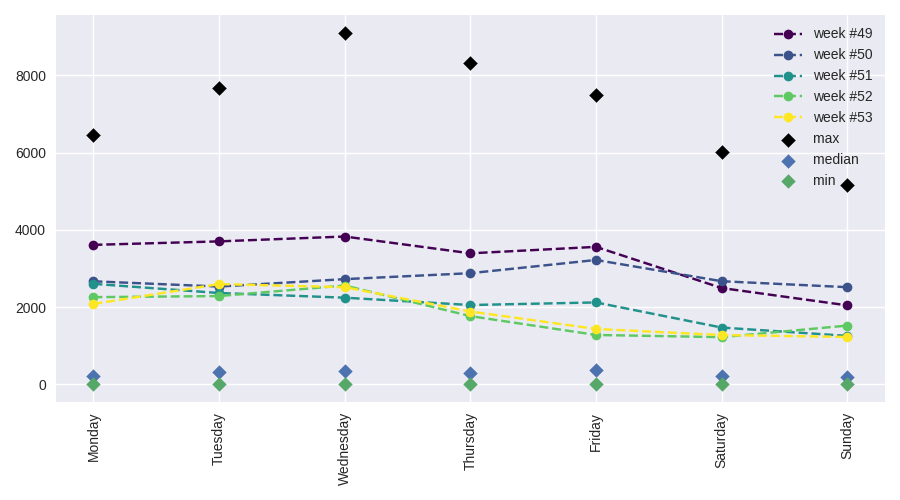

<AxesSubplot:>

In [99]:
AT.plot_cases_by_day_of_the_week(num_weeks_history=5)

### Time Series

<IPython.core.display.Javascript object>


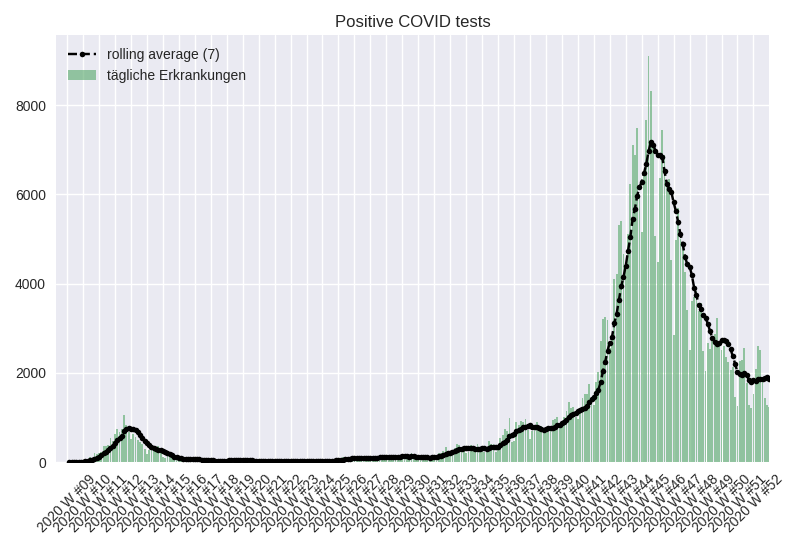

[Timestamp('2020-02-25 00:00:00'), Timestamp('2021-01-03 00:00:00')]


In [100]:

# ax.bar(df_at.time, df_at['tägliche Erkrankungen'],label='recorded',  alpha=0.6, color='C1')

ax = AT.plot_tägliche_erkrankungen(roll_days=7, ndays=0)

# selection =  ecdc.select_country('AT',   ndays=1000,).sort_values(by=['dateRep'], ascending=True,)
# # ax.plot(,.rolling(14).mean(), marker='o', markersize=4, linestyle='--')
# ax = plot_rolling_avg(ax,selection.dateRep, y= selection['cases_weekly'], roll_days=14, label='ECDC', color='C0')

# plt.yscale('log')


plt.xticks(rotation=45);
plt.legend(loc='best')
plt.tight_layout()

# AT.epicurve['tägliche Erkrankungen'], ecdc.select_country('AT').cases_weekly.sum()



### Last 5 days

In [101]:
AT.epicurve.sort_values('time').tail(7)

,time,tägliche Erkrankungen,Timestamp,weekday
307,2020-12-28,2083,2021-01-04T09:02:00,0
308,2020-12-29,2597,2021-01-04T09:02:00,1
309,2020-12-30,2517,2021-01-04T09:02:00,2
310,2020-12-31,1887,2021-01-04T09:02:00,3
311,2021-01-01,1436,2021-01-04T09:02:00,4
312,2021-01-02,1278,2021-01-04T09:02:00,5
313,2021-01-03,1229,2021-01-04T09:02:00,6


### Cases prediction

<IPython.core.display.Javascript object>


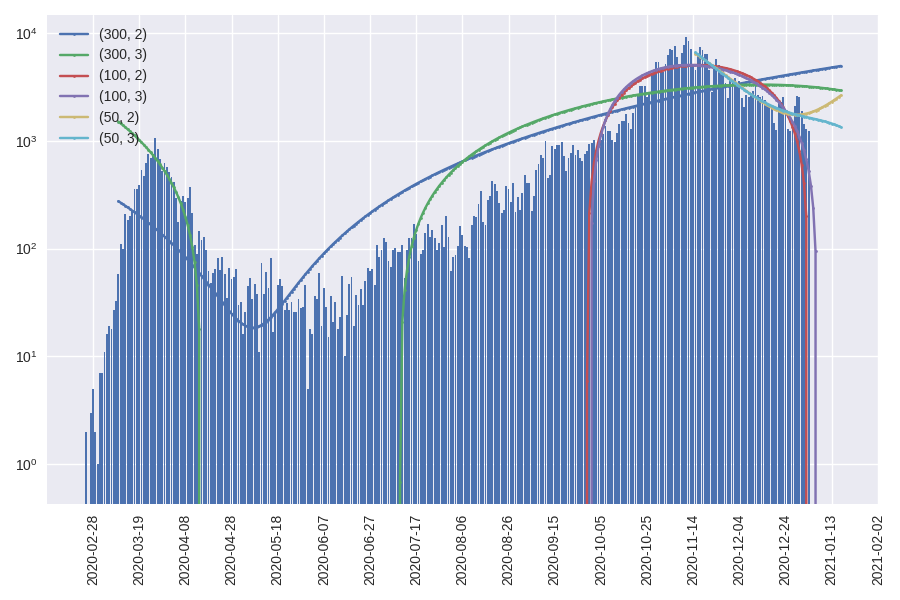

In [112]:

f, ax = plt.subplots(figsize=(9,6))
ax.bar(AT.epicurve.time, AT.epicurve['tägliche Erkrankungen'])
for hist in [300,100,50]:
    for df in [2,3]:
        x, y = predict_future(AT.epicurve.time, AT.epicurve['tägliche Erkrankungen'], ndays=hist, predict_days=14, degree_fit=df)        
        ax.plot(x, y, label=f'({hist}, {df})', linestyle='-', marker='o', markersize=2)
        
# plt.legend(loc='best')
pretty_plot(ax, log=True)

## Number of Cases

### Vienna

2021-01-01 00:00:00


<IPython.core.display.Javascript object>


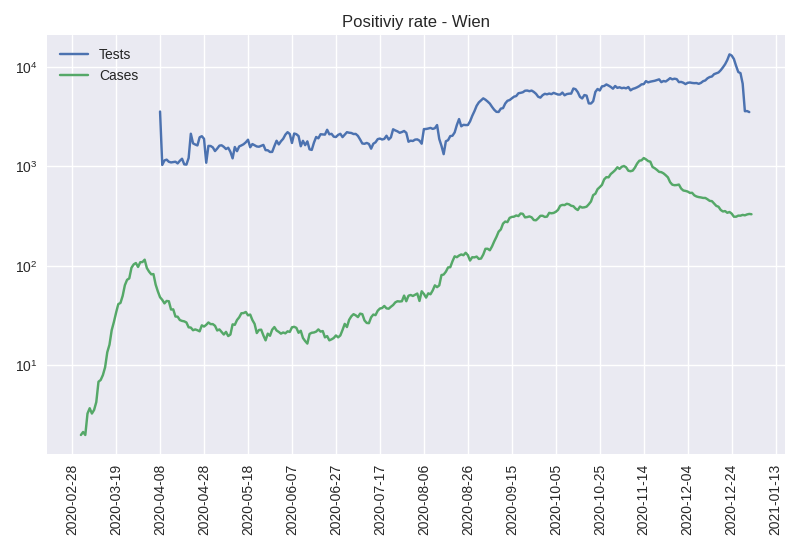

<AxesSubplot:title={'center':'Positiviy rate - Wien'}>

In [113]:
AT.plot_positivity_rate(bundesland='Wien')

### Cases and Deaths (from ECDC)

<IPython.core.display.Javascript object>


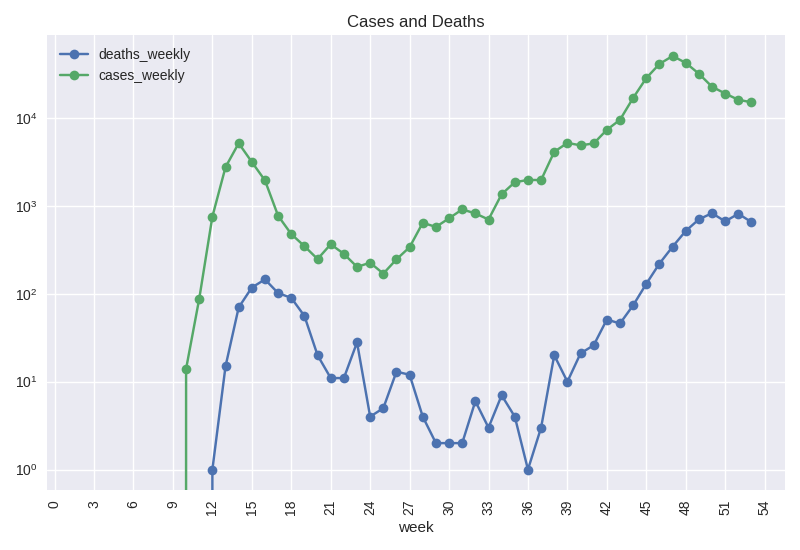

In [115]:
df_at = ecdc.df[ecdc.df.geoId=='AT']
f,ax=plt.subplots()
df_at.groupby(by=df_at.dateRep.dt.isocalendar().week).agg({'deaths_weekly':latest, 'cases_weekly': latest}).plot(ax=ax,marker='o')
pretty_plot(ax=ax,log=True,title='Cases and Deaths')

## Corona Ampel

In [116]:
ampel = AT.ampel_aktuell

# ampel.sort_values('Warnstufe', ascending=False).head(10)
ampel.groupby('Warnstufe').agg({'Name':concat, 'Region': 'count'})

,Name,Region
Warnstufe,,
4,"Eisenstadt(Stadt), Rust(Stadt), Eisenstadt-Umgebung, Güssing, Jennersdorf, Mattersburg, Neusiedl am See, Oberpullendorf, Oberwart, Klagenfurt Stadt, Villach Stadt, Hermagor, Klagenfurt Land, Sankt Veit an der Glan, Spittal an der Drau, Villach Land, Völkermarkt, Wolfsberg, Feldkirchen, Krems an der Donau(Stadt), Sankt Pölten(Stadt), Waidhofen an der Ybbs(Stadt), Wiener Neustadt(Stadt), Amstetten, Baden, Bruck an der Leitha, Gänserndorf, Gmünd, Hollabrunn, Horn, Korneuburg, Krems(Land), Lilienfeld, Melk, Mistelbach, Mödling, Neunkirchen, Sankt Pölten(Land), Scheibbs, Tulln, Waidhofen an der Thaya, Wiener Neustadt(Land), Zwettl, Linz(Stadt), Steyr(Stadt), Wels(Stadt), Braunau am Inn, Eferding, Freistadt, Gmunden, Grieskirchen, Kirchdorf an der Krems, Linz-Land, Perg, Ried im Innkreis, Rohrbach, Schärding, Steyr-Land, Urfahr-Umgebung, Vöcklabruck, Wels-Land, Salzburg(Stadt), Hallein, Salzburg-Umgebung, Sankt Johann im Pongau, Tamsweg, Zell am See, Graz(Stadt), Deutschlandsberg, Graz-Umgebung, Leibnitz, Leoben, Liezen, Murau, Voitsberg, Weiz, Murtal, Bruck-Mürzzuschlag, Hartberg-Fürstenfeld, Südoststeiermark, Innsbruck-Stadt, Imst, Innsbruck-Land, Kitzbühel, Kufstein, Landeck, Lienz, Reutte, Schwaz, Bludenz, Bregenz, Dornbirn, Feldkirch, Burgenland, Kärnten, Niederösterreich, Oberösterreich, Salzburg, Steiermark, Tirol, Vorarlberg, Wien, Bartholomäberg, Blons, Bludenz, Bludesch, Brand, Bürs, Bürserberg, Dalaas, Fontanella, Gaschurn, Innerbraz, Klösterle, Lech, Lorüns, Ludesch, Nenzing, Nüziders, Raggal, St. Anton im Montafon, St. Gallenkirch, St. Gerold, Schruns, Silbertal, Sonntag, Stallehr, Thüringen, Thüringerberg, Tschagguns, Vandans, Alberschwende, Andelsbuch, Au, Bezau, Bildstein, Bizau, Bregenz, Buch, Damüls, Doren, Egg, Eichenberg, Fußach, Gaißau, Hard, Hittisau, Höchst, Hörbranz, Hohenweiler, Kennelbach, Krumbach, Langen bei Bregenz, Langenegg, Lauterach, Lingenau, Lochau, Mellau, Mittelberg, Möggers, Reuthe, Riefensberg, Schnepfau, Schoppernau, Schröcken, Schwarzach, Schwarzenberg, Sibratsgfäll, Sulzberg, Warth, Wolfurt, Dornbirn, Hohenems, Lustenau, Altach, Düns, Dünserberg, Feldkirch, Frastanz, Fraxern, Göfis, Götzis, Klaus, Koblach, Laterns, Mäder, Meiningen, Rankweil, Röns, Röthis, Satteins, Schlins, Schnifis, Sulz, Übersaxen, Viktorsberg, Weiler, Zwischenwasser, nan",199


## Future Occupancy

In [117]:
def predict_future(past_days, past_y, ndays=14, predict_days=30, degree_fit=2):
    '''
    @ndays: number of days to consider from the end for predicting future
    '''
    past_y = np.array(past_y)
    future = np.arange(0,ndays+predict_days)
    past_days = past_days.dt.to_pydatetime()
    future_days = pd.date_range(start =past_days[-ndays], 
                                end =past_days[-1]+ timedelta(days=predict_days)).to_list()

    x = np.arange(ndays)
    z = np.polyfit(x,past_y[-ndays:], degree_fit)    
    p = np.poly1d(z)    
    return future_days, p(future)


In [118]:
NDAYS=30
latest_df = AT.fall_zählen[AT.fall_zählen.MeldeDatum==AT.fall_zählen.MeldeDatum.max()].sort_values('FZHospFree')
print(f'As of {AT.fall_zählen.MeldeDatum.max()}')
data = []
for bundesland in AT.fall_zählen.Bundesland.unique():
    bundesland_data = {'bundesland': bundesland}
    df = AT.fall_zählen[AT.fall_zählen.Bundesland==bundesland]
    limit_ICU = latest_df[latest_df.Bundesland==bundesland].FZICUFree.iloc[0]  + latest_df[latest_df.Bundesland==bundesland].FZICU.iloc[0]
    limit_Hosp = latest_df[latest_df.Bundesland==bundesland].FZHospFree.iloc[0]  + latest_df[latest_df.Bundesland==bundesland].FZHosp.iloc[0]
    bundesland_data['ICUFree'] = latest_df[latest_df.Bundesland==bundesland].FZICUFree.iloc[0]
    bundesland_data['HospFree'] = latest_df[latest_df.Bundesland==bundesland].FZHospFree.iloc[0]
    predict_days =  300
    days_left_icu = []
    days_left_hosp = []
    for degree_fit in (1,2,3):
        
        x,y = predict_future(df.MeldeDatum, df.FZICU, ndays=NDAYS, predict_days=predict_days, degree_fit=degree_fit)
        if y[np.argmax(y>=limit_ICU)] >= limit_ICU:
            days_left_icu.append( np.argmax(y>=limit_ICU)-NDAYS)
        else:
            days_left_icu.append(1000)

        x,y = predict_future(df.MeldeDatum, df.FZHosp, ndays=NDAYS, predict_days=predict_days, degree_fit=degree_fit)
        if y[np.argmax(y>=limit_Hosp)] >= limit_Hosp:
            days_left_hosp.append( np.argmax(y>=limit_Hosp)-NDAYS)
        else:
            days_left_hosp.append( 1000)


        
    bundesland_data['daysLeftICU'] = days_left_icu    
    bundesland_data['ICUMax_worst'] = AT.fall_zählen.MeldeDatum.max() + timedelta(days=int(min(days_left_icu)))
    bundesland_data['ICUMax_best'] = AT.fall_zählen.MeldeDatum.max() + timedelta(days=int(max(days_left_icu)))
    bundesland_data['daysLeftHosp'] = days_left_hosp
    
    bundesland_data['HospMax_worst'] = AT.fall_zählen.MeldeDatum.max() + timedelta(days=int(min(days_left_hosp)))
    bundesland_data['HospMax_best'] = AT.fall_zählen.MeldeDatum.max() + timedelta(days=int(max(days_left_hosp)))

    data.append(bundesland_data)
    
df_future = pd.DataFrame(data)
df_future.sort_values(by='ICUFree')

As of 2021-01-01 00:00:00


,bundesland,ICUFree,HospFree,daysLeftICU,ICUMax_worst,ICUMax_best,daysLeftHosp,HospMax_worst,HospMax_best
0,Burgenland,18,144,"[1000, 20, 1000]",2021-01-21,2023-09-28,"[1000, 1000, 1000]",2023-09-28,2023-09-28
6,Tirol,21,152,"[-30, -30, -30]",2020-12-02,2020-12-02,"[-30, -30, -30]",2020-12-02,2020-12-02
4,Salzburg,25,106,"[1000, 1000, 1000]",2023-09-28,2023-09-28,"[1000, 1000, 6]",2021-01-07,2023-09-28
3,Oberösterreich,30,766,"[-30, -30, -30]",2020-12-02,2020-12-02,"[1000, 105, 41]",2021-02-11,2023-09-28
7,Vorarlberg,31,159,"[1000, 42, 16]",2021-01-17,2023-09-28,"[1000, 1000, 29]",2021-01-30,2023-09-28
1,Kärnten,47,338,"[1000, 97, 14]",2021-01-15,2023-09-28,"[1000, 1000, 14]",2021-01-15,2023-09-28
5,Steiermark,85,662,"[1000, 159, 1000]",2021-06-09,2023-09-28,"[1000, 1000, 19]",2021-01-20,2023-09-28
2,Niederösterreich,134,696,"[1000, 1000, 27]",2021-01-28,2023-09-28,"[1000, 69, 33]",2021-02-03,2023-09-28
8,Wien,224,3021,"[1000, 1000, 18]",2021-01-19,2023-09-28,"[1000, 1000, 46]",2021-02-16,2023-09-28
9,Alle,615,6044,"[1000, 1000, 30]",2021-01-31,2023-09-28,"[1000, 1000, 27]",2021-01-28,2023-09-28


### Plots

<IPython.core.display.Javascript object>


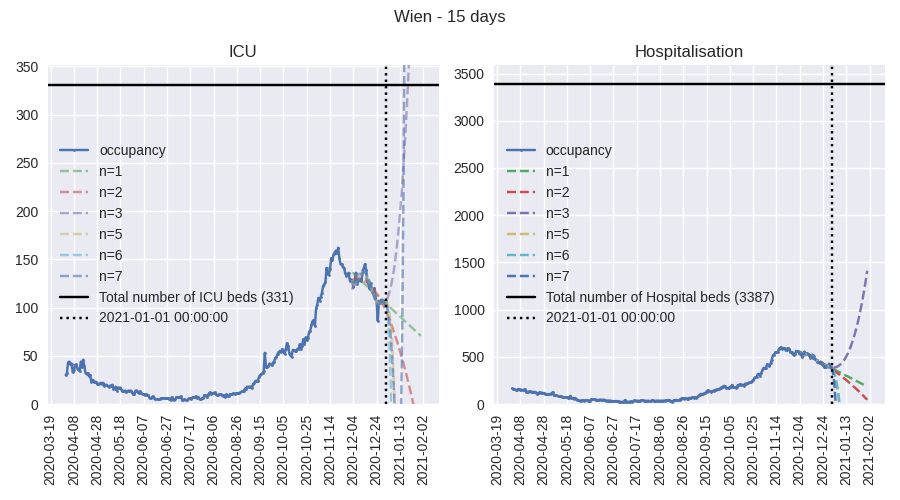

<IPython.core.display.Javascript object>


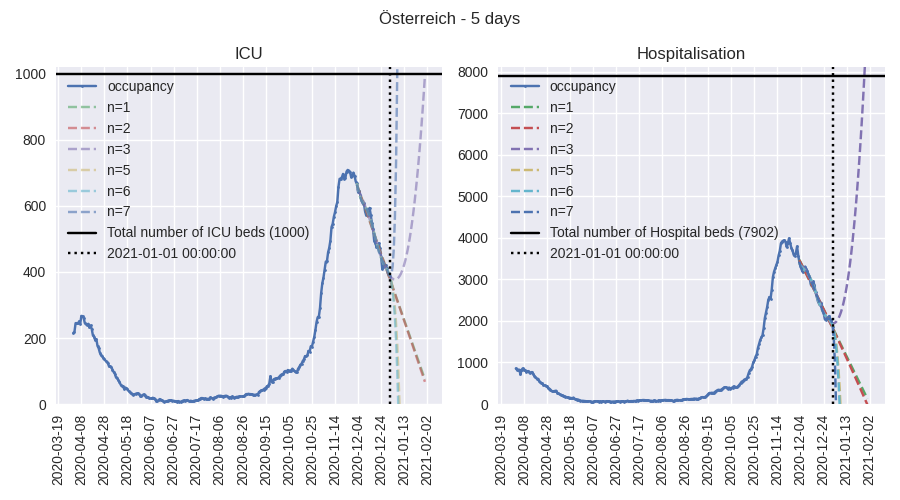

In [119]:


latest_df = AT.fall_zählen[AT.fall_zählen.MeldeDatum==AT.fall_zählen.MeldeDatum.max()].sort_values('FZHospFree')
for bundesland in [ 'Wien', 'Alle']:
    f, ax = plt.subplots(ncols=2,sharex=True, figsize=(9,5))
    df = AT.fall_zählen[AT.fall_zählen.Bundesland==bundesland]
    limit_ICU = latest_df[latest_df.Bundesland==bundesland].FZICUFree.iloc[0]  + \
                latest_df[latest_df.Bundesland==bundesland].FZICU.iloc[0]
    limit_Hosp = latest_df[latest_df.Bundesland==bundesland].FZHospFree.iloc[0]  + \
                 latest_df[latest_df.Bundesland==bundesland].FZHosp.iloc[0]

    predict_days =  max(int(latest_df.FZICUFree.iloc[0]),30)

    ax[0].plot(df.MeldeDatum, df.FZICU, label='occupancy', marker='o',markersize=2)
    ax[1].plot(df.MeldeDatum, df.FZHosp, label='occupancy', marker='o',markersize=2)

#     print(latest_df[latest_df.Bundesland==bundesland].MeldeDatum.iloc[0])
    days_left_ICU = []
    days_left_Hosp = []
    for degree_fit in (1,2,3,5,6,7):
        
        x,y = predict_future(df.MeldeDatum, df.FZICU, ndays=NDAYS, predict_days=predict_days, degree_fit=degree_fit)
        ax[0].plot(x, y, linestyle='--', label=f'n={degree_fit}', alpha=0.6)
        if y[np.argmax(y>=limit_ICU)] >= limit_ICU:
            days_left_ICU.append(np.argmax(y>=limit_ICU)-NDAYS)
       
        x,y = predict_future(df.MeldeDatum, df.FZHosp, ndays=NDAYS, predict_days=predict_days, degree_fit=degree_fit)
        ax[1].plot(x, y, linestyle='--', label=f'n={degree_fit}')
        if y[np.argmax(y>=limit_Hosp)] >= limit_Hosp:
            days_left_Hosp.append(np.argmax(y>=limit_Hosp)-NDAYS)
        
    ax[0].axhline(y=limit_ICU,color='k', label=f'Total number of ICU beds ({limit_ICU})')
    ax[1].axhline(y=limit_Hosp,color='k', label=f'Total number of Hospital beds ({limit_Hosp})')
    ax[0].set_ylim(0,limit_ICU+20)
    ax[1].set_ylim(0,limit_Hosp+200)
    ax[0].axvline(x=latest_df[latest_df.Bundesland==bundesland].MeldeDatum.iloc[0],
           color='k', linestyle='dotted',
           label=latest_df[latest_df.Bundesland==bundesland].MeldeDatum.iloc[0])
    ax[1].axvline(x=latest_df[latest_df.Bundesland==bundesland].MeldeDatum.iloc[0],
           color='k', linestyle='dotted',
           label=latest_df[latest_df.Bundesland==bundesland].MeldeDatum.iloc[0])

    title = bundesland if bundesland != 'Alle' else 'Österreich'
    if days_left_ICU:
        title = f'{title} - {min(days_left_ICU)} days'
    
    f.suptitle(title)
    ax[0].set_ylim(0,)
    pretty_plot(ax[0], title='ICU')
    pretty_plot(ax[1],title='Hospitalisation')
        
#     plt.savefig(f'ICU_{today}_{bundesland}.png')



## Bed capacity

<IPython.core.display.Javascript object>


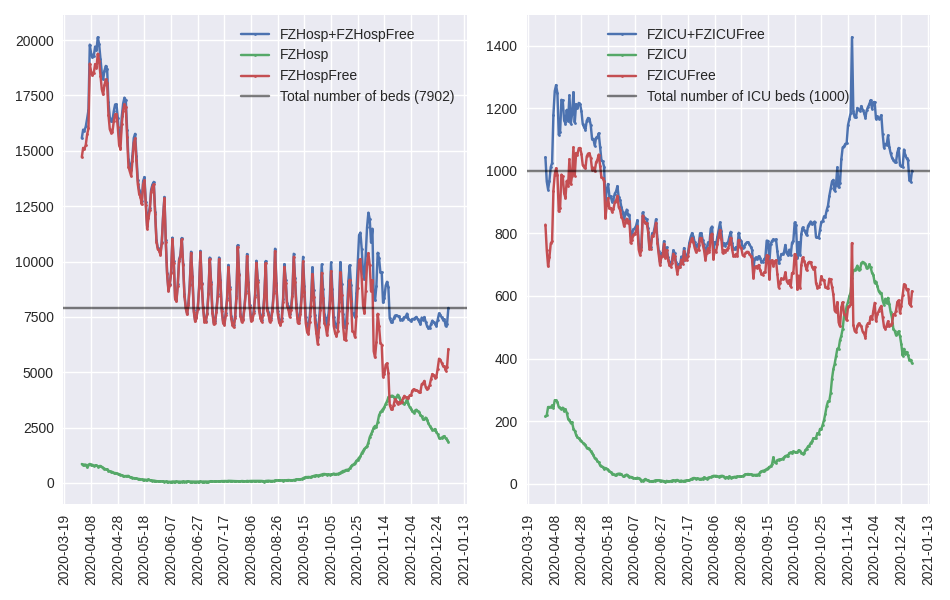

In [120]:
df = AT.fall_zählen[AT.fall_zählen.Bundesland=='Alle']

f,ax = plt.subplots(ncols=2, figsize=(9.5,6))
ax[0].plot(df.MeldeDatum, df.FZHosp+df.FZHospFree, label='FZHosp+FZHospFree',markersize=2, marker='o')    
ax[0].plot(df.MeldeDatum, df.FZHosp, label='FZHosp',markersize=2, marker='o')    
ax[0].plot(df.MeldeDatum, df.FZHospFree, label='FZHospFree',markersize=2, marker='o') 
ax[1].plot(df.MeldeDatum, df.FZICU+df.FZICUFree, label='FZICU+FZICUFree',markersize=2, marker='o')    
ax[1].plot(df.MeldeDatum, df.FZICU, label='FZICU',markersize=2, marker='o')    
ax[1].plot(df.MeldeDatum, df.FZICUFree, label='FZICUFree',markersize=2, marker='o')    
ax[0].axhline(y=df.FZHospFree.iloc[-1]+df.FZHosp.iloc[-1],color='k', label=f'Total number of beds ({limit_Hosp})',alpha=0.5)
ax[1].axhline(y=df.FZICUFree.iloc[-1]+df.FZICU.iloc[-1],color='k', label=f'Total number of ICU beds ({limit_ICU})',alpha=0.5)
# ax[0].set_ylabel('Number of Hospital Beds')
# ax[1].set_ylabel('Number of ICU Beds')
pretty_plot(ax[0])
pretty_plot(ax[1])

## Deaths

In [121]:
from gestorbene import Gestorbene
G = Gestorbene()
max(G.under_65.week_end)

Timestamp('2020-12-13 00:00:00')

### Overall Deaths

<IPython.core.display.Javascript object>


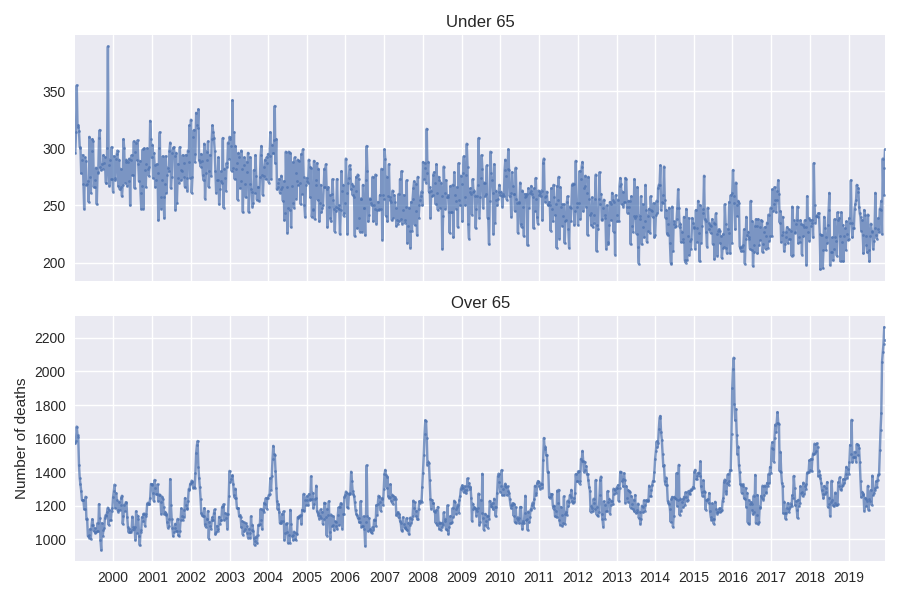

In [122]:
dates = pd.date_range(start=min(G.under_65.week_end), end = max(G.under_65.week_end),freq='Y',closed='left')
f, ax = plt.subplots(figsize=(9,6), sharex=True, nrows=2)
G.under_65.groupby(['week_end']).sum()['F-ANZ-1'].plot(ax=ax[0], alpha=0.7, marker='o', markersize=2, title='Under 65')
G.over_65.groupby(['week_end']).sum()['F-ANZ-1'].plot(ax=ax[1], alpha=0.7, marker='o', markersize=2, title='Over 65')
plt.xlabel('')
plt.ylabel('Number of deaths')
plt.xticks(dates, dates.strftime('%Y'))
plt.tight_layout()

### Group by month and year

<IPython.core.display.Javascript object>


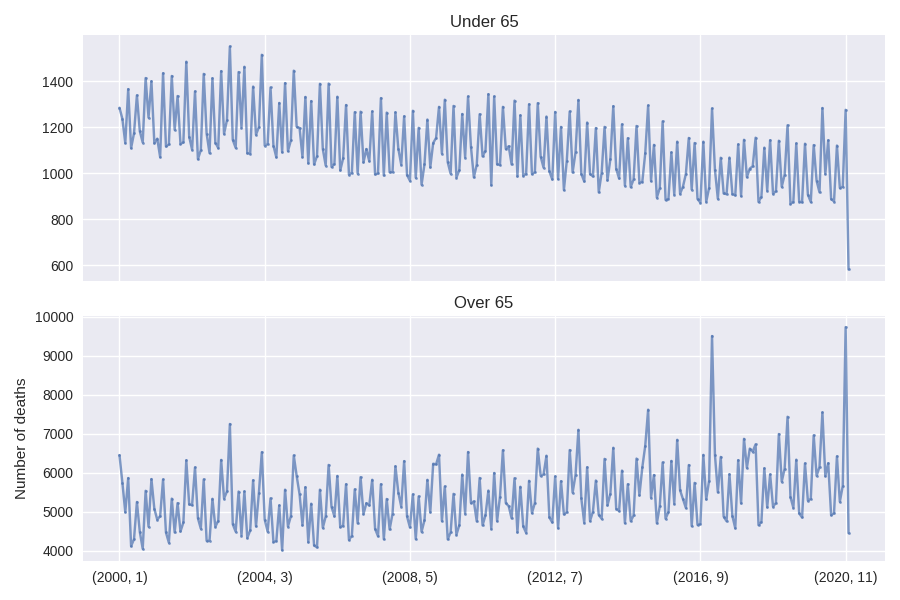

In [123]:
from matplotlib.ticker import FormatStrFormatter
dates = pd.date_range(start=min(G.under_65.week_end), end = max(G.under_65.week_end),freq='M')

f, ax = plt.subplots(figsize=(9,6), sharex=True,nrows=2)
G.under_65.groupby(by=[G.under_65.week_end.dt.year, G.under_65.week_end.dt.month]).sum()['F-ANZ-1'].plot(ax=ax[0], alpha=0.7, marker='o', markersize=2, title='Under 65')
G.over_65.groupby(by=[G.over_65.week_end.dt.year, G.over_65.week_end.dt.month]).sum()['F-ANZ-1'].plot(ax=ax[1], alpha=0.7, marker='o', markersize=2, title='Over 65')
plt.xlabel('')
plt.ylabel('Number of deaths')
# ax[1].xaxis.set_major_locator(plt.MaxNLocator(50));

# plt.xticks(dates,zip( dates.strftime('%Y'),dates.strftime('%M')));
# ax[1].xaxis.set_major_formatter(FormatStrFormatter('%Y'));

plt.tight_layout()

### By Sex

<IPython.core.display.Javascript object>


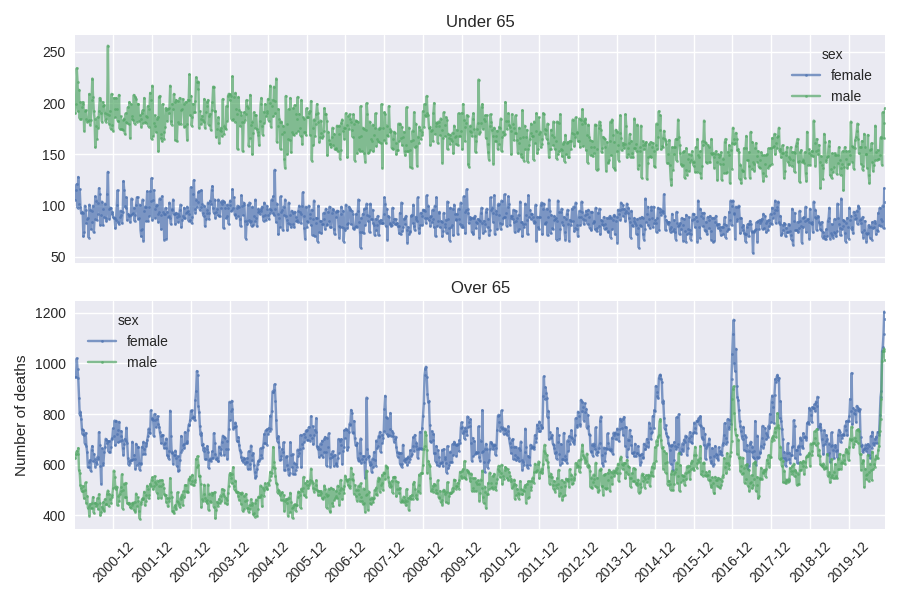

In [124]:
dates = pd.date_range(start=min(G.under_65.week_end), end = max(G.under_65.week_end),freq='Y',closed='left')
f, ax = plt.subplots(figsize=(9,6), sharex=True, nrows=2)
G.under_65.groupby(['week_end','sex']).sum()['F-ANZ-1'].unstack().plot(ax=ax[0], alpha=0.7, marker='o', markersize=2, title='Under 65')
G.over_65.groupby(['week_end','sex']).sum()['F-ANZ-1'].unstack().plot(ax=ax[1], alpha=0.7, marker='o', markersize=2, title='Over 65')
plt.xlabel('')
plt.xticks(rotation=45)

plt.ylabel('Number of deaths')
plt.xticks(dates, dates.strftime('%Y-%m'));
plt.tight_layout()

### Yearly

<IPython.core.display.Javascript object>


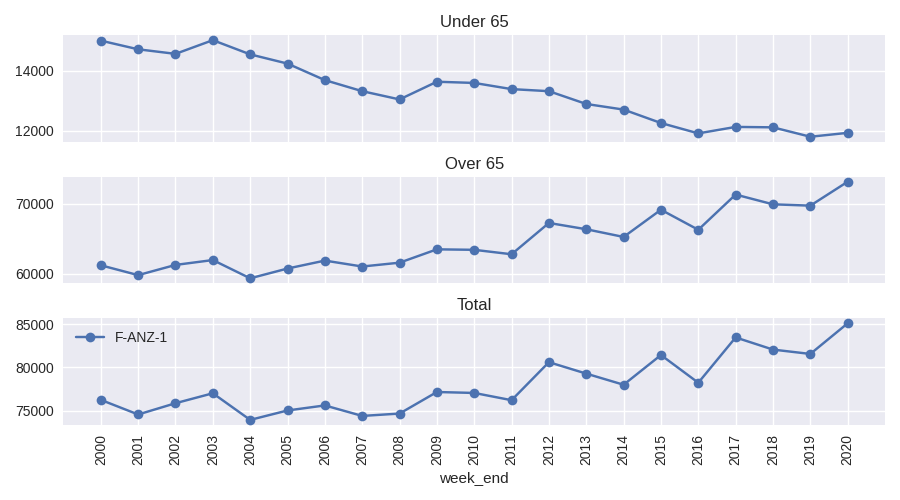

In [125]:
current_year = datetime.now().year
dfs = {'Under 65': G.under_65,
      'Over 65':  G.over_65,
      'Total': pd.concat([G.under_65, G.over_65])}

f, ax = plt.subplots(figsize=(9,5),nrows=len(dfs), sharex=True, sharey=False)
i = 0
for title, df in dfs.items():
    grouped = df.groupby(by=[df.week_end.dt.year]).agg('sum')
    grouped.head()
    grouped['F-ANZ-1'].plot(ax=ax[i], marker='o', title=title)
    i += 1
# 
pretty_plot(ax[-1],xticks=[df.week_end.dt.year.unique(),])


## Total number of deaths in Austria in 2020

### COVID

### All deaths

In [126]:
all_deaths = pd.concat([G.under_65, G.over_65])
all_deaths[all_deaths.week_end.dt.year == 2020]['F-ANZ-1'].sum()

85109

In [127]:
from matplotlib import cm


## Cumulative deaths in a year

[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


<IPython.core.display.Javascript object>


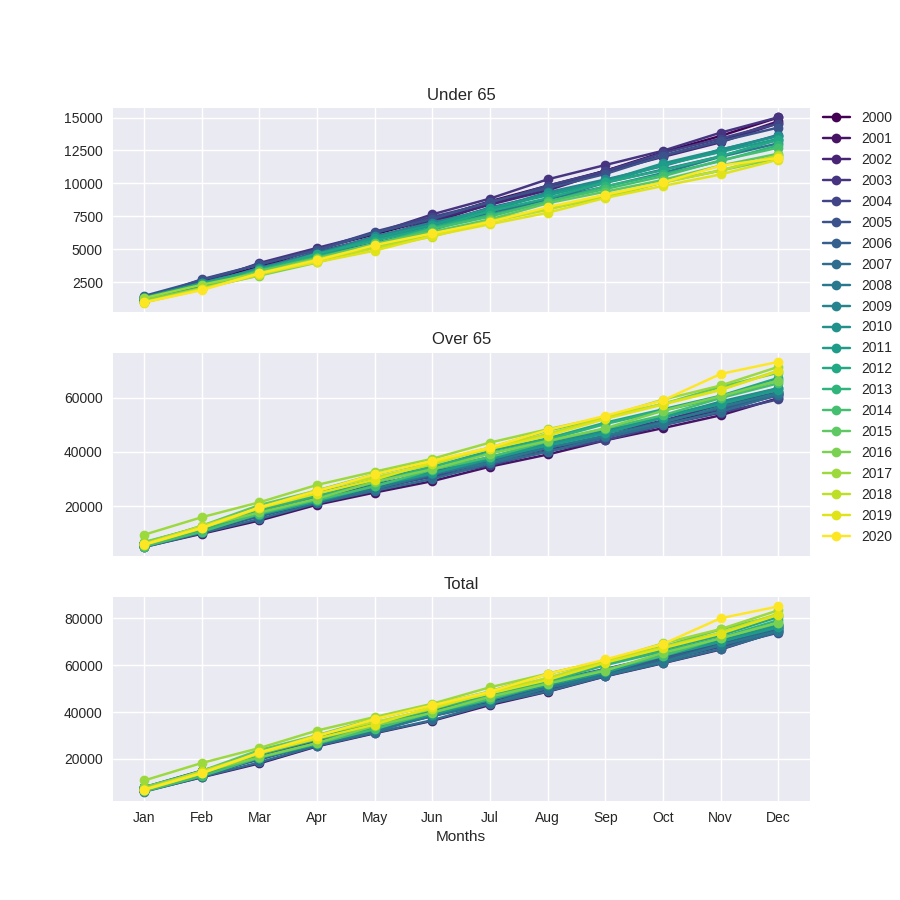

<ipython-input-128-b9d16bfb8370>:31: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


In [128]:
current_year = datetime.now().year
NUM_YEARS = 10
YEARS = sorted(list(all_deaths.week_end.dt.year.unique()))#[-5:]
print(YEARS)
viridis = cm.get_cmap('viridis', len(YEARS))

# df.head()
dfs = {'Under 65': G.under_65,
      'Over 65':  G.over_65,
      'Total': pd.concat([G.under_65, G.over_65])}

f, ax = plt.subplots(figsize=(9,9),nrows=len(dfs), sharex=True, sharey=False)
j = -1
for title, all_deaths in dfs.items():
    j += 1
    for i, y in enumerate(YEARS):    
        if y == current_year:
            color='w'
        else:
            color=viridis.colors[i]
            
        df_year = all_deaths[all_deaths.week_end.dt.year == y]
        grouped = df_year.groupby(by=[all_deaths.week_end.dt.month]).agg('sum')        
        grouped['F-ANZ-1'].cumsum().plot(ax=ax[j], marker='o',label=y, title=title,c=color)
    

plt.xlabel('Months')    
plt.xticks(ticks=range(1,13), labels=['Jan', 'Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend(bbox_to_anchor=(1, 1.2), loc='lower left')    

plt.tight_layout()
    
